<a href="https://colab.research.google.com/github/edgar-avilan-tf9/project-repo/blob/Pix2PixHD/CityPix2Pixv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!unzip /content/drive/MyDrive/GANdataset/gtFine_trainvaltest.zip -d /content/city_scapes
!rm /content/city_scapes/license.txt
!rm /content/city_scapes/README

In [2]:
%%capture
!unzip /content/drive/MyDrive/GANdataset/leftImg8bit_trainvaltest.zip -d /content/city_scapes

In [3]:
import os
import torch
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
from torch import nn

In [4]:
from pix2pixHD_utils import *

In [5]:
class CityscapesDataset(torch.utils.data.Dataset):
    '''
    CityscapesDataset Class
    Values:
        paths: (a list of) paths to load examples from, a list or string
        target_width: the size of image widths for resizing, a scalar
        n_classes: the number of object classes, a scalar
    '''

    def __init__(self, paths, target_width=1024, n_classes=35):
        super().__init__()

        self.n_classes = n_classes

        # Collect list of examples
        self.examples = {}
        if type(paths) == str:
            self.load_examples_from_dir(paths)
        elif type(paths) == list:
            for path in paths:
                self.load_examples_from_dir(path)
        else:
            raise ValueError('`paths` should be a single path or list of paths')

        self.examples = list(self.examples.values())
        assert all(len(example) == 3 for example in self.examples)

        # Initialize transforms for the real color image
        self.img_transforms = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, Image.BICUBIC)),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        # Initialize transforms for semantic label and instance maps
        self.map_transforms = transforms.Compose([
            transforms.Lambda(lambda img: scale_width(img, target_width, Image.NEAREST)),
            transforms.Lambda(lambda img: np.array(img)),
            transforms.ToTensor(),
        ])

    def load_examples_from_dir(self, abs_path):
        '''
        Given a folder of examples, this function returns a list of paired examples.
        '''
        assert os.path.isdir(abs_path)

        img_suffix = '_leftImg8bit.png'
        label_suffix = '_gtFine_labelIds.png'
        inst_suffix = '_gtFine_instanceIds.png'

        for root, _, files in os.walk(abs_path):
          if 'train' in root:
              for f in files:
                  if f.endswith(img_suffix):
                      prefix = f[:-len(img_suffix)]
                      attr = 'orig_img'
                  elif f.endswith(label_suffix):
                      prefix = f[:-len(label_suffix)]
                      attr = 'label_map'
                  elif f.endswith(inst_suffix):
                      prefix = f[:-len(inst_suffix)]
                      attr = 'inst_map'
                  else:
                      continue

                  if prefix not in self.examples.keys():
                      self.examples[prefix] = {}
                  self.examples[prefix][attr] = root + '/' + f

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Load image and maps
        img = Image.open(example['orig_img']).convert('RGB') # color image: (3, 512, 1024)
        inst = Image.open(example['inst_map'])               # instance map: (512, 1024)
        label = Image.open(example['label_map'])             # semantic label map: (512, 1024)

        # Apply corresponding transforms
        img = self.img_transforms(img)
        inst = self.map_transforms(inst)
        label = self.map_transforms(label).long() * 255

        # Convert labels to one-hot vectors
        label = torch.zeros(self.n_classes, img.shape[1], img.shape[2]).scatter_(0, label, 1.0).to(img.dtype)

        # Convert instance map to instance boundary map
        bound = torch.ByteTensor(inst.shape).zero_()
        bound[:, :, 1:] = bound[:, :, 1:] | (inst[:, :, 1:] != inst[:, :, :-1])
        bound[:, :, :-1] = bound[:, :, :-1] | (inst[:, :, 1:] != inst[:, :, :-1])
        bound[:, 1:, :] = bound[:, 1:, :] | (inst[:, 1:, :] != inst[:, :-1, :])
        bound[:, :-1, :] = bound[:, :-1, :] | (inst[:, 1:, :] != inst[:, :-1, :])
        bound = bound.to(img.dtype)

        return (img, label, inst, bound)

    def __len__(self):
        return len(self.examples)

    @staticmethod
    def collate_fn(batch):
        imgs, labels, insts, bounds = [], [], [], []
        for (x, l, i, b) in batch:
            imgs.append(x)
            labels.append(l)
            insts.append(i)
            bounds.append(b)
        return (
            torch.stack(imgs, dim=0),
            torch.stack(labels, dim=0),
            torch.stack(insts, dim=0),
            torch.stack(bounds, dim=0),
        )

In [14]:
from tqdm import tqdm
from torch.utils.data import DataLoader

n_classes = 35                  # total number of object classes
rgb_channels = n_features = 3
device = 'cuda'
train_dir = ['/content/city_scapes']
epochs = 20                    # total number of train epochs
decay_after = 10               # number of epochs with constant lr
lr = 0.0002
betas = (0.5, 0.999)

def lr_lambda(epoch):
    ''' Function for scheduling learning '''
    return 1. if epoch < decay_after else 1 - float(epoch - decay_after) / (epochs - decay_after)

def weights_init(m):
    ''' Function for initializing all model weights '''
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0., 0.02)

loss_fn = Loss(device=device)

## Phase 1: Low Resolution (1024 x 512)
dataloader1 = DataLoader(
    CityscapesDataset(train_dir, target_width=1024, n_classes=n_classes),
    collate_fn=CityscapesDataset.collate_fn, batch_size=2, shuffle=True, drop_last=False, pin_memory=True,
)
encoder = Encoder(rgb_channels, n_features).to(device).apply(weights_init)
generator1 = GlobalGenerator(n_classes + n_features + 1, rgb_channels).to(device).apply(weights_init)
discriminator1 = MultiscaleDiscriminator(n_classes + 1 + rgb_channels, n_discriminators=2).to(device).apply(weights_init)

g1_optimizer = torch.optim.Adam(list(generator1.parameters()) + list(encoder.parameters()), lr=lr, betas=betas)
d1_optimizer = torch.optim.Adam(list(discriminator1.parameters()), lr=lr, betas=betas)
g1_scheduler = torch.optim.lr_scheduler.LambdaLR(g1_optimizer, lr_lambda)
d1_scheduler = torch.optim.lr_scheduler.LambdaLR(d1_optimizer, lr_lambda)


## Phase 2: High Resolution (2048 x 1024)
dataloader2 = DataLoader(
    CityscapesDataset(train_dir, target_width=2048, n_classes=n_classes),
    collate_fn=CityscapesDataset.collate_fn, batch_size=2, shuffle=True, drop_last=False, pin_memory=True,
)
generator2 = LocalEnhancer(n_classes + n_features + 1, rgb_channels).to(device).apply(weights_init)
discriminator2 = MultiscaleDiscriminator(n_classes + 1 + rgb_channels).to(device).apply(weights_init)

g2_optimizer = torch.optim.Adam(list(generator2.parameters()) + list(encoder.parameters()), lr=lr, betas=betas)
d2_optimizer = torch.optim.Adam(list(discriminator2.parameters()), lr=lr, betas=betas)
g2_scheduler = torch.optim.lr_scheduler.LambdaLR(g2_optimizer, lr_lambda)
d2_scheduler = torch.optim.lr_scheduler.LambdaLR(d2_optimizer, lr_lambda)

In [15]:
def scale_width(img, target_width, method):
    '''
    Function that scales an image to target_width while retaining aspect ratio.
    '''
    w, h = img.size
    if w == target_width: return img
    target_height = target_width * h // w
    return img.resize((target_width, target_height), method)

In [16]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Parse torch version for autocast
# ######################################################
version = torch.__version__
version = tuple(int(n) for n in version.split('.')[:-1])
has_autocast = version >= (1, 6)
# ######################################################

def show_tensor_images(image_tensor):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:1], nrow=1)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def train(dataloader, models, optimizers, schedulers, device, tr_name):
    encoder, generator, discriminator = models
    g_optimizer, d_optimizer = optimizers
    g_scheduler, d_scheduler = schedulers

    cur_step = 0
    display_step = 600

    mean_g_loss = 0.0
    mean_d_loss = 0.0

    for epoch in range(epochs):
        # Training epoch
        for (x_real, labels, insts, bounds) in tqdm(dataloader, position=0):
            x_real = x_real.to(device)
            labels = labels.to(device)
            insts = insts.to(device)
            bounds = bounds.to(device)

            # Enable autocast to FP16 tensors (new feature since torch==1.6.0)
            # If you're running older versions of torch, comment this out
            # and use NVIDIA apex for mixed/half precision training
            if has_autocast:
                with torch.cuda.amp.autocast(enabled=(device=='cuda')):
                    g_loss, d_loss, x_fake = loss_fn(
                        x_real, labels, insts, bounds, encoder, generator, discriminator
                    )
            else:
                g_loss, d_loss, x_fake = loss_fn(
                    x_real, labels, insts, bounds, encoder, generator, discriminator
                )

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            mean_g_loss += g_loss.item() / display_step
            mean_d_loss += d_loss.item() / display_step

            if cur_step % display_step == 0 and cur_step > 0:
                print('Step {}: Generator loss: {:.5f}, Discriminator loss: {:.5f}'
                      .format(cur_step, mean_g_loss, mean_d_loss))
                show_tensor_images(x_fake.to(x_real.dtype))
                show_tensor_images(x_real)
                mean_g_loss = 0.0
                mean_d_loss = 0.0
            cur_step += 1
        torch.save(generator.state_dict(), tr_name)

        g_scheduler.step()
        d_scheduler.step()

 40%|████      | 600/1488 [15:14<23:22,  1.58s/it]

Step 600: Generator loss: 1.70351, Discriminator loss: 0.67499


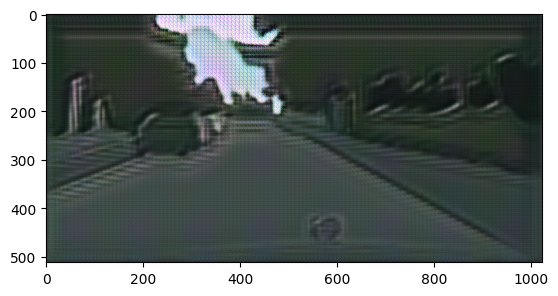

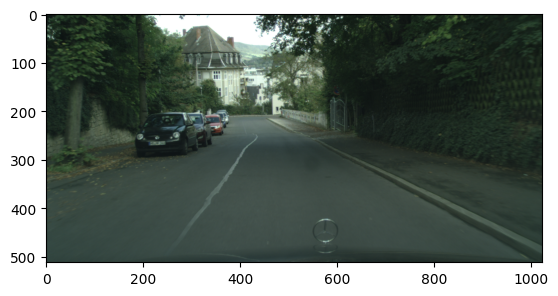

 81%|████████  | 1200/1488 [30:48<07:10,  1.50s/it]

Step 1200: Generator loss: 1.52999, Discriminator loss: 0.51199


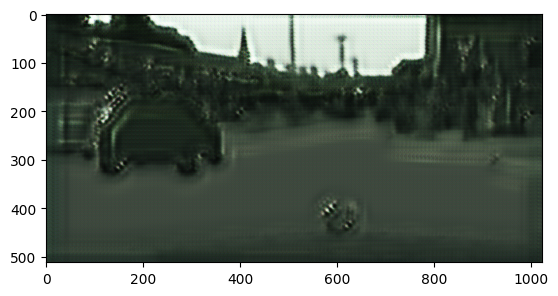

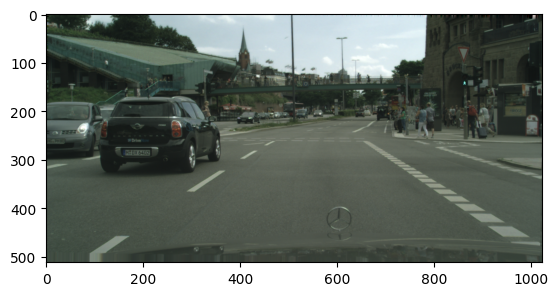

 20%|█▉        | 295/1488 [07:41<31:23,  1.58s/it]

In [ ]:
# Phase 1: Low Resolution
#######################################################################
train(
    dataloader1,
    [encoder, generator1, discriminator1],
    [g1_optimizer, d1_optimizer],
    [g1_scheduler, d1_scheduler],
    device,'CityModel1.pt'
)


# Phase 2: High Resolution
#######################################################################
# Update global generator in local enhancer with trained
generator2.g1 = generator1.g1

# Freeze encoder and wrap to support high-resolution inputs/outputs
def freeze(encoder):
    encoder.eval()
    for p in encoder.parameters():
        p.requires_grad = False

    @torch.jit.script
    def forward(x, inst):
        x = F.interpolate(x, scale_factor=0.5, recompute_scale_factor=True)
        inst = F.interpolate(inst.float(), scale_factor=0.5, recompute_scale_factor=True)
        feat = encoder(x, inst.int())
        return F.interpolate(feat, scale_factor=2.0, recompute_scale_factor=True)
    return forward

train(
    dataloader2,
    [freeze(encoder), generator2, discriminator2],
    [g2_optimizer, d2_optimizer],
    [g2_scheduler, d2_scheduler],
    device,'CityModel2.pt'
)